# Computational Modeling - Lab2 - Clustering

Natalie Pham

Andrew ID: thanhngp

## Summary
#### 1. Preprocessing
- Loaded data with pandas - a total of 969 rows and 1025 columns
- 1024 columns of type 'int64', 1 columns represent the 'ID' of type 'object'.
- Excluded the 'ID' column from the dataset since it does not contribute to the goal of clustering the records into groups, according to the methods used in this notebook.
- No NaN values are found.

Note: Observed that 1024 columns of type 'int64' likely are binary encodings of categorical data.

#### 2. K-means Clustering
- Determined the optimal number of clusters using the elbow method. Performed the standard k-means clustering (distance metric as 'euclidean') with the optimal number of 4 clusters, which was found using the elbow method. 
- Applied tSNE as a dimensional reduction approach for the dataset to visualize the clusters in 2 dimensions, and color-coded the clusters with labels found with the K-means method.

#### 3. Other Clustering Methods
- Agglomerative clustering - a hierarchical bottom-up approach
    * Experimented with agglomerative clustering on the following pairs of linkages and distance metrics:  (ward, Euclidean), (average, Cosine), (average, Jaccard), (average, Hamming).
    * Plotted the dendrogram and performed clustering with different linkages and metrics. 
    * Observed that the result obtained using (ward, euclidean) and (average, hamming) are better compared to what obtained with ('average', 'Cosine') and ('average', 'Jaccard'). This could be explained by the fact that our data are observed to be categorical (or binary). 'Cosine' distance (which measures the angle between two datapoints) and 'Jaccard' distance (when only values of elements in the sets were considered for dissimilarity measure but not the position within the sets) do not work as well as the 'Euclidean' (the standard sum of square differences) and 'Hamming' distances (which measures the dissimilarity between two strings of equal length and works well for strings of binary).
    * The tSNE plot with clusters color-coded by agglomerative clustering using 'ward' linkage and 'Euclidean' distance metric is very similar to what was obtained in the plot with clusters color-coded using the K-means model in 2. This is logical since both methods used 'Euclidean' as a distance metric, so the clusters represent how close the data points within a group are in terms of 'Euclidean' measures.
    * The agglomerative clustering using 'average' linkage and 'Hamming' distance metric returned the optimal number of clusters to be 5 clusters, which is slightly different from what was achieved with K-means, K-modes, and agglomerative clustering using (ward, Euclidean).
    
- K-modes - an approach for categorical data
    * Used elbow method to determine the optimal number of clusters.
    * Performed K-modes with 4 clusters. Plotted the result in 2 dimensions and color-coded using the label obtained by K-modes. The 4 clusters achieved with K-modes are similar to that achieved with the standard K-means approach in 2.
    
- DBSCAN - a choice based on observation of tSNE 2-dimensional plot
    * From the 2-dimensional plot visualized with features reduced by tSNE, observed that there are 9 separate groups of points. This could be well labeled with DBSCAN approach with appropriate parameters since this method views clusters as areas of high density separated by areas of low density. 
    * Experimented with DBSCAN using the following distance metrics (which I believed they are most suitable for the given dataset): Euclidean, Hamming. 9 clusters obtained from the dataset with a very small number of points cannot be clustered. Same results achieved regardless of using Euclidean or Hamming after tuned the hyperparameters and visualized.
    
##### References:
- 39-615A Lecture 5: Unsupervised Learning
- https://scikit-learn.org/stable/modules/clustering.html#clustering
- https://joydipnath.medium.com/clustering-technique-for-categorical-data-in-python-8eb0f581b6f9
- https://aiaspirant.com/distance-similarity-measures-in-machine-learning/

In [1]:
# uncomment to install packakes
# !pip install yellowbrick

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

### 1. Preprocessing

In [3]:
# Import the dataset
df = pd.read_csv("lab2_clustering_dataset.csv")
df.head()

,ID,D_0,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,...,D_1014,D_1015,D_1016,D_1017,D_1018,D_1019,D_1020,D_1021,D_1022,D_1023
0,AAEAMMIUQZAASJ-MRXNPFEDSA-N,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,1,1,1
1,AAEFNWQXBPYXAC-UHFFFAOYSA-N,1,1,1,1,0,1,1,1,0,...,1,0,1,1,1,0,0,1,1,1
2,AAMHSIWFDKXUMZ-UHFFFAOYSA-N,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,0,0,1,1
3,AAPQXEOSVSLLMB-UHFFFAOYSA-N,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,AARXXEHXOBTROW-UHFFFAOYSA-N,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,1,1,1


In [4]:
# Information on datatypes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Columns: 1025 entries, ID to D_1023
dtypes: int64(1024), object(1)
memory usage: 7.6+ MB
None


In [5]:
summary = df.describe()
summary.head(8)

,D_0,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,D_9,...,D_1014,D_1015,D_1016,D_1017,D_1018,D_1019,D_1020,D_1021,D_1022,D_1023
count,969.0,969.000000,969.0,969.0,969.000000,969.0,969.000000,969.00000,969.000000,969.000000,...,969.000000,969.000000,969.0,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,1.0,0.900929,1.0,1.0,0.684211,1.0,0.764706,0.68937,0.570691,0.373581,...,0.860681,0.737874,1.0,0.881321,0.854489,0.681115,0.553148,0.809082,0.821465,0.912281
std,0.0,0.298912,0.0,0.0,0.465070,0.0,0.424402,0.46299,0.495233,0.484004,...,0.346458,0.440018,0.0,0.323577,0.352797,0.466285,0.497424,0.393228,0.383160,0.283032
min,1.0,0.000000,1.0,1.0,0.000000,1.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,1.0,1.0,0.000000,1.0,1.000000,0.00000,0.000000,0.000000,...,1.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.00000,1.000000,0.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
NaN_cols = df.columns[df.isna().any()].tolist() # locate columns with missing values
if len(NaN_cols) == 0:
    print('No null value found!')
else:
    print(NaN_cols) 

No null value found!


In [7]:
# Separate ID from numerical columns
target = df['ID']
data = df.drop(['ID'],axis=1)
print(target.shape,data.shape)

(969,) (969, 1024)


In [8]:
def check_const(col_list):
    # col_list (list of str): list of features' names in df
    # list1, list2: whether all values in features are (and almost are) the same
    
    list1 = []
    for col in list(col_list):
        if summary[col]['min']==summary[col]['max']: # check if all values in column are the same. 
            list1.append(col)
    return(list1)

In [9]:
const_col = check_const(data)
print(len(const_col),' Columns with values are constant: ', const_col)
print()

74  Columns with values are constant:  ['D_0', 'D_2', 'D_3', 'D_5', 'D_29', 'D_32', 'D_36', 'D_64', 'D_70', 'D_103', 'D_104', 'D_153', 'D_160', 'D_161', 'D_171', 'D_172', 'D_180', 'D_194', 'D_208', 'D_246', 'D_252', 'D_255', 'D_257', 'D_258', 'D_263', 'D_276', 'D_281', 'D_282', 'D_294', 'D_296', 'D_310', 'D_330', 'D_371', 'D_381', 'D_383', 'D_400', 'D_427', 'D_432', 'D_472', 'D_499', 'D_529', 'D_544', 'D_556', 'D_573', 'D_622', 'D_626', 'D_632', 'D_633', 'D_677', 'D_684', 'D_708', 'D_717', 'D_729', 'D_735', 'D_750', 'D_760', 'D_762', 'D_786', 'D_790', 'D_792', 'D_796', 'D_838', 'D_842', 'D_843', 'D_865', 'D_872', 'D_881', 'D_883', 'D_905', 'D_917', 'D_986', 'D_991', 'D_1013', 'D_1016']



### 2. K-means clustering & optimize number of clusters

#### K-means using 'euclidean' distance

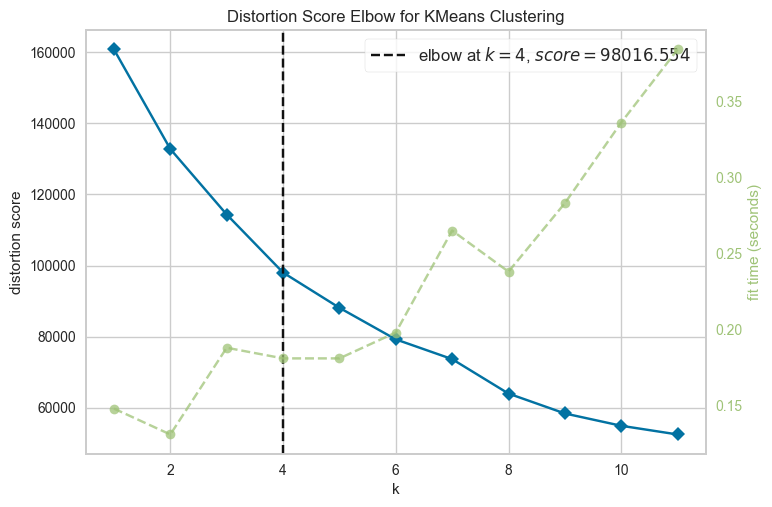

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Elbow method
model = KMeans()
elbow_opt_cluster = KElbowVisualizer(model, k=(1,12),distance_metric="euclidean",metric="distortion")

elbow_opt_cluster.fit(np.array(data))        # Find the optimal number of cluster using elbow method
elbow_opt_cluster.show()

In [11]:
N_clusters = elbow_opt_cluster.elbow_value_ # Take number of clusters to be optimal number of clusters found with elbow method.
model = KMeans(n_clusters=N_clusters).fit(data)
centroid = model.cluster_centers_
# results
label_kmean_euclidean = model.predict(data)

#### Visualize results using the dimensionality reduction (tSNE)

In [12]:
# function for plotting clusters in 2 dimensions
def plot_cluster(tsne_feature, label):
    with plt.style.context(("seaborn", "ggplot")):
        fig,ax = plt.subplots(1, figsize=(10, 6))

        points = ax.scatter(tsne_feature[:,0],tsne_feature[:,1], c=label, s=20, cmap="plasma")
        fig.colorbar(points)

        plt.xlabel("tSNE 1")
        plt.ylabel("tSNE 2")
        plt.title('Visualizing the clusters with tSNE')
        plt.show()

In [13]:
tsne = manifold.TSNE(n_components=2,perplexity=20,random_state=11,n_iter=500) # default metric is Euclidean
tsne_feature = tsne.fit_transform(data)

C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


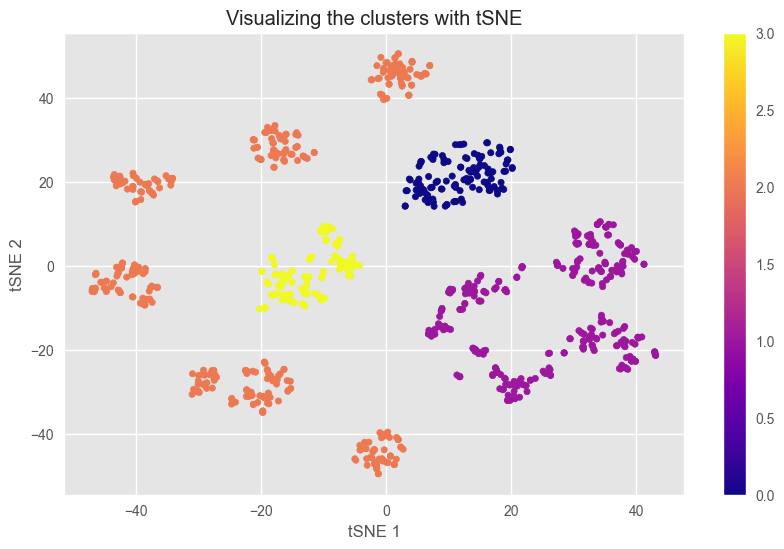

In [14]:
plot_cluster(tsne_feature,label_kmean_euclidean)

### 3. Perform clustering with different clustering methods

#### 3.1 Agglomerative Clustering

##### Use 'ward' linkage and 'euclidean' distance

In [15]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

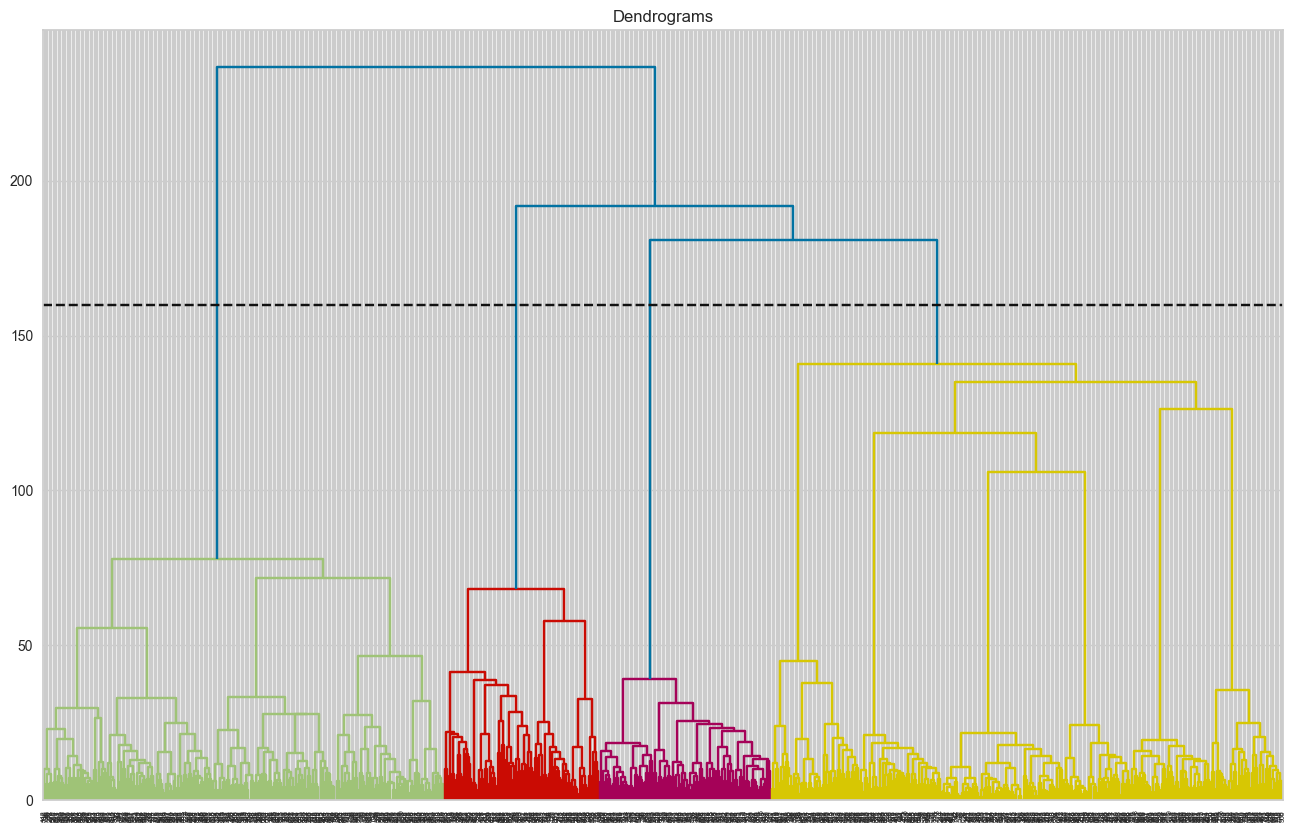

In [16]:
plt.figure(figsize=(16, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data, method='ward',metric='euclidean')) 
plt.axhline(y=160, color='k', linestyle='--')

In [17]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
label_aggloClustering = cluster.fit_predict(data)

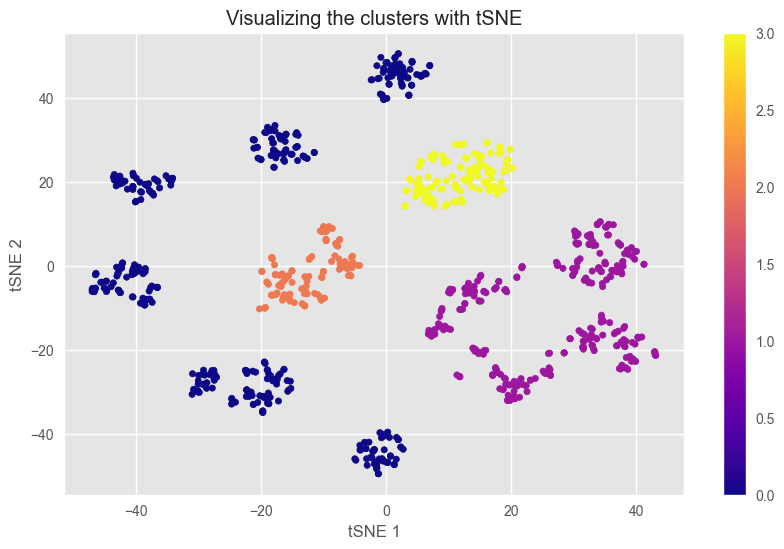

In [18]:
plot_cluster(tsne_feature,label_aggloClustering)

##### Use 'average' linkage and 'cosine' distance metric

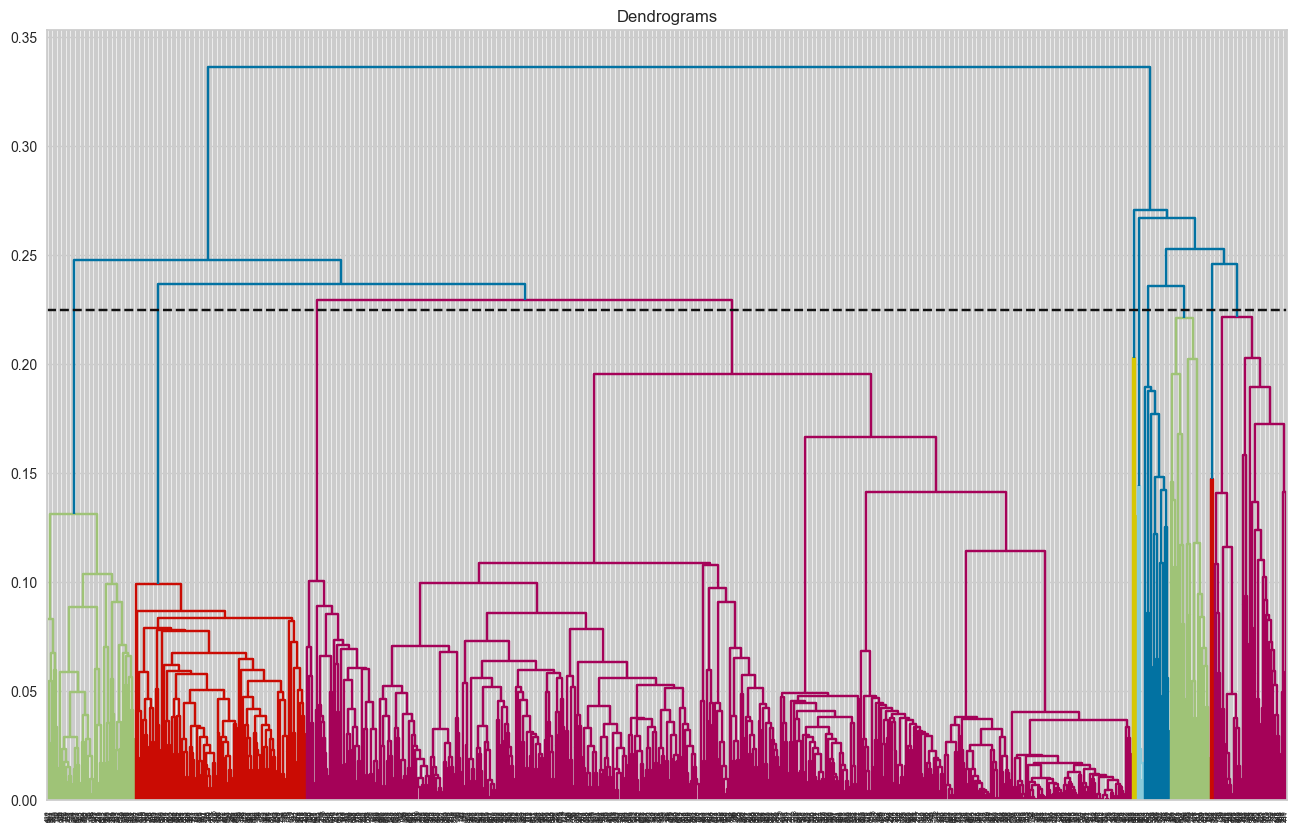

In [19]:
plt.figure(figsize=(16, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data, method='average',metric='cosine'))
plt.axhline(y=0.225, color='k', linestyle='--')

In [20]:
cluster = AgglomerativeClustering(n_clusters=9, affinity='cosine', linkage='average')  
label_aggloClustering = cluster.fit_predict(data)

In [21]:
tsne = manifold.TSNE(n_components=2,perplexity=20,random_state=11,n_iter=500,metric='cosine')
tsne_feature = tsne.fit_transform(data)

C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


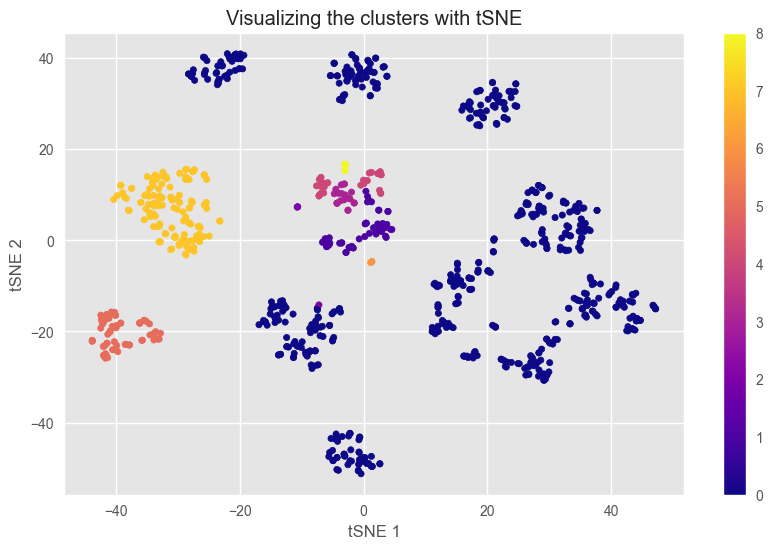

In [22]:
plot_cluster(tsne_feature,label_aggloClustering)

##### Use 'average' linkage and 'jaccard' distance metric

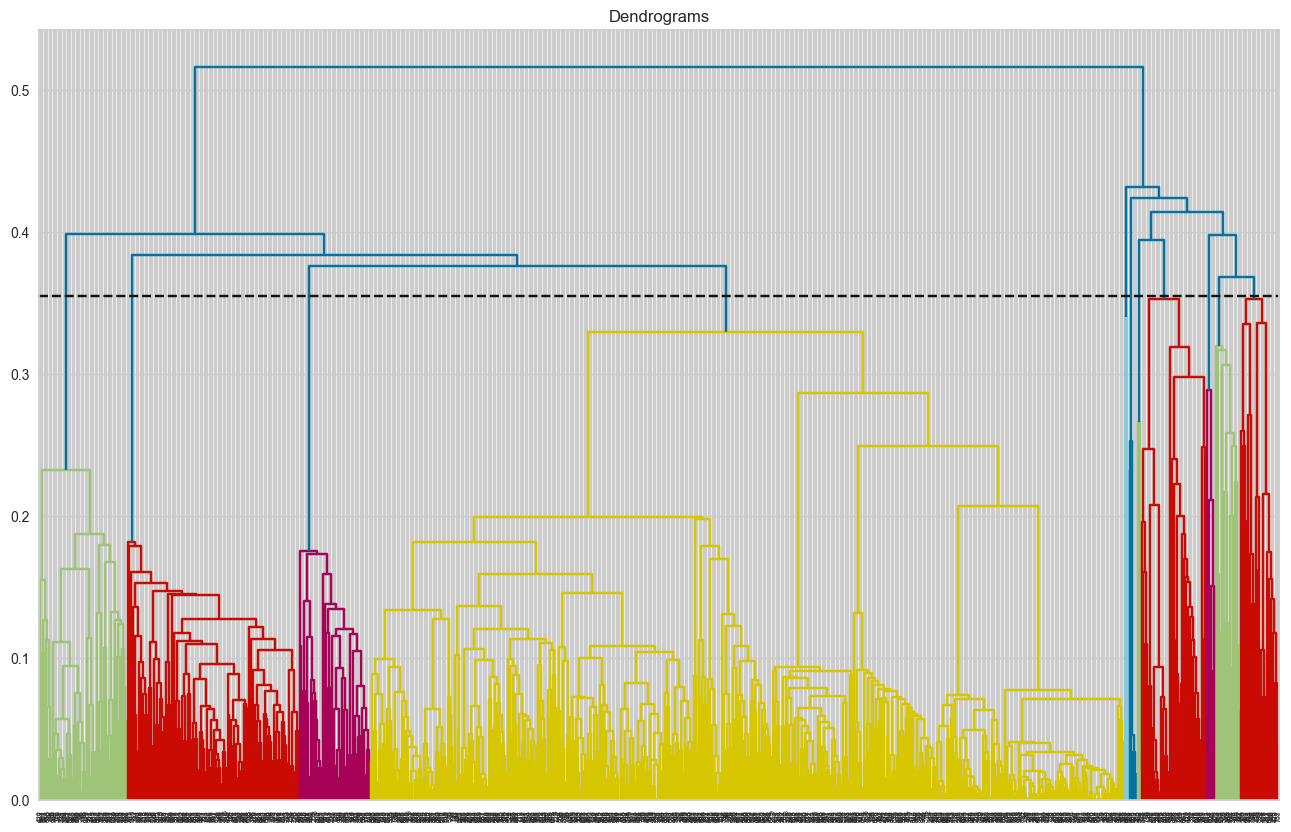

In [23]:
plt.figure(figsize=(16, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data, method='average',metric='jaccard'))
plt.axhline(y=0.355, color='k', linestyle='--')

In [24]:
cluster = AgglomerativeClustering(n_clusters=11, affinity='jaccard', linkage='average')  
label_aggloClustering = cluster.fit_predict(data)

In [25]:
tsne = manifold.TSNE(n_components=2,perplexity=20,random_state=11,n_iter=500,metric='jaccard')
tsne_feature = tsne.fit_transform(data)

C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\metrics\pairwise.py:1875: DataConversionWarning: Data was converted to boolean for me

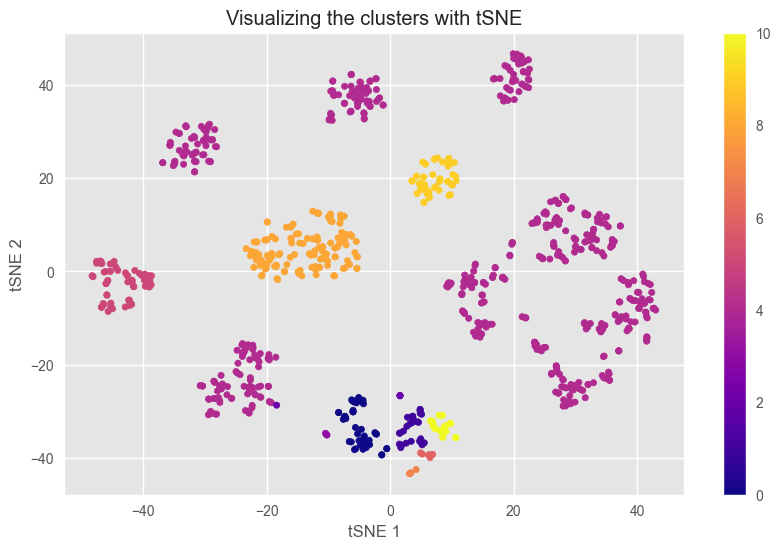

In [26]:
plot_cluster(tsne_feature,label_aggloClustering)

##### Use 'average' linkage and 'hamming' distance metric

Observed the dataset may contain only binary values (0's and 1's), perform the hierarchical clustering with hamming distance metric, which measures the minimum number of substitutions required to change one string into the other.

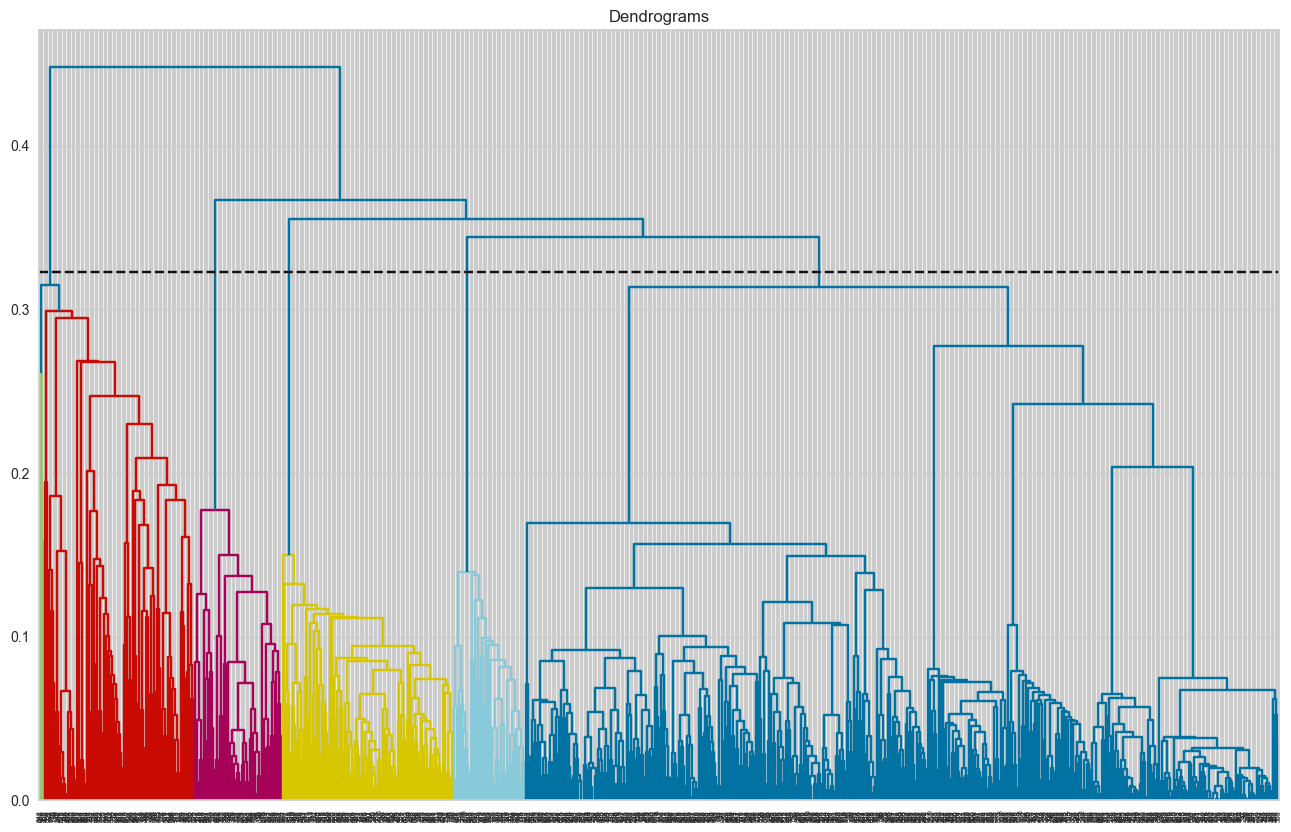

In [27]:
plt.figure(figsize=(16, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data, method='average',metric='hamming'))
plt.axhline(y=0.323, color='k', linestyle='--')

In [28]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='hamming', linkage='average')  
label_aggloClustering = cluster.fit_predict(data)

In [29]:
tsne = manifold.TSNE(n_components=2,perplexity=20,random_state=11,n_iter=500,metric='hamming')
tsne_feature = tsne.fit_transform(data)

C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


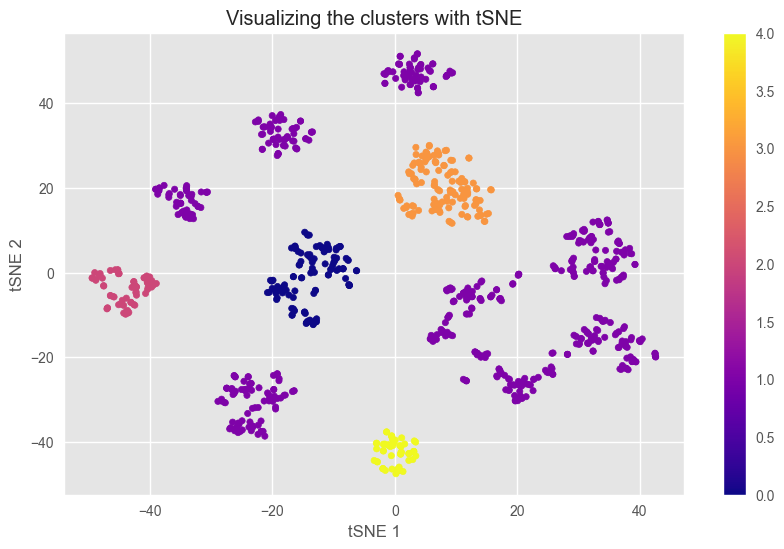

In [30]:
plot_cluster(tsne_feature,label_aggloClustering)

#### 3.2 K-modes

In [31]:
# !pip install kmodes
from kmodes.kmodes import KModes

Best run was number 1
Best run was number 1
Best run was number 5
Best run was number 4
Best run was number 4
Best run was number 4
Best run was number 4
Best run was number 3
Best run was number 2


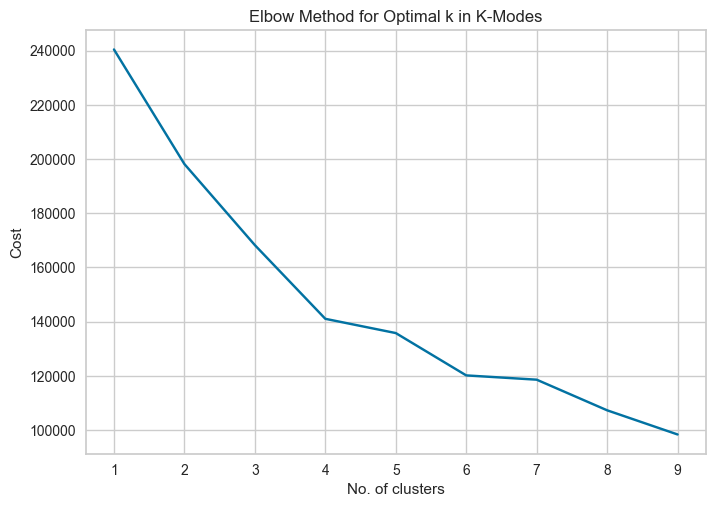

In [32]:
# Apply elbow method to find optimal k
cost = []
K = range(1,10)
for n in list(K):
    kmode = KModes(n_jobs=-1, n_clusters=n, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(np.array(data))
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k in K-Modes')
plt.show()

In [33]:
kmode = KModes(n_jobs=-1, n_clusters=4, init = "random", n_init = 5, verbose=1)
label_kmode = kmode.fit_predict(data)

Best run was number 5


In [34]:
tsne = manifold.TSNE(n_components=2,perplexity=20,random_state=11,n_iter=500,metric='euclidean')
tsne_feature = tsne.fit_transform(data)

C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


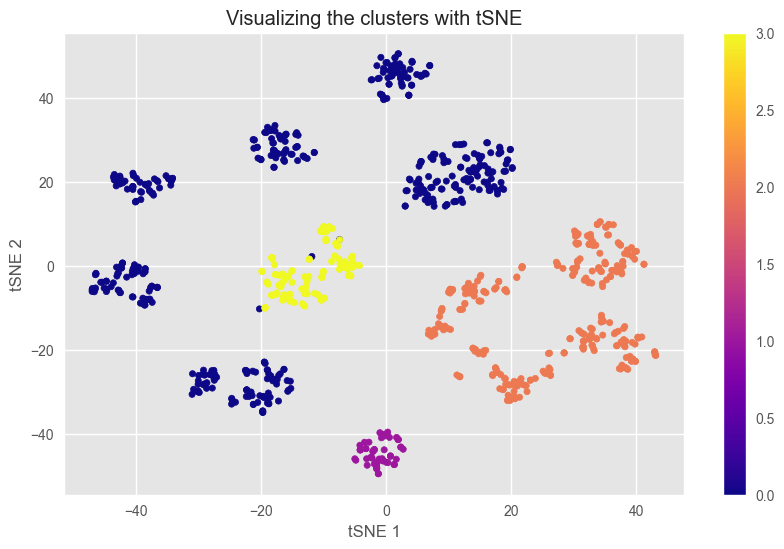

In [35]:
plot_cluster(tsne_feature,label_kmode)

#### 3.3 DBSCAN

In [36]:
from sklearn.cluster import DBSCAN

In [37]:
tsne = manifold.TSNE(n_components=2,perplexity=20,random_state=11,n_iter=500,metric='euclidean')
tsne_feature = tsne.fit_transform(data)

C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


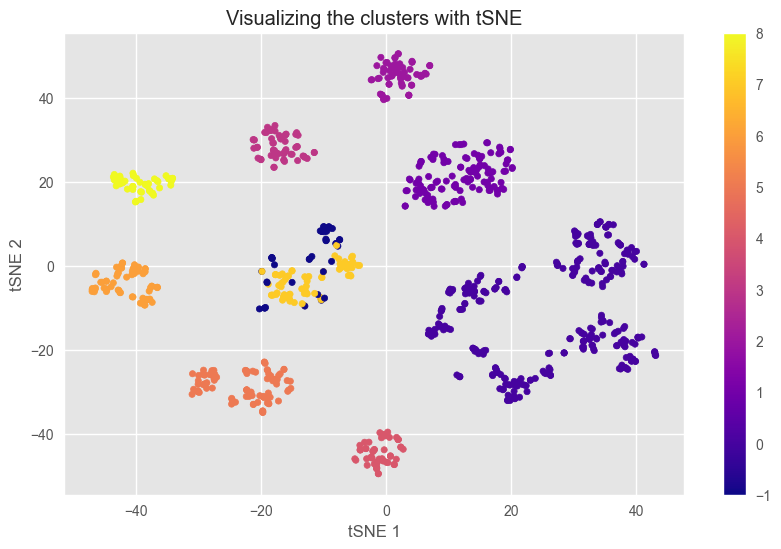

In [38]:
dbscan = DBSCAN(eps=12, min_samples=20, metric='euclidean').fit(data)
label_dbscan = dbscan.labels_
plot_cluster(tsne_feature,label_dbscan)

In [39]:
tsne = manifold.TSNE(n_components=2,perplexity=20,random_state=11,n_iter=500,metric='hamming')
tsne_feature = tsne.fit_transform(data)

C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


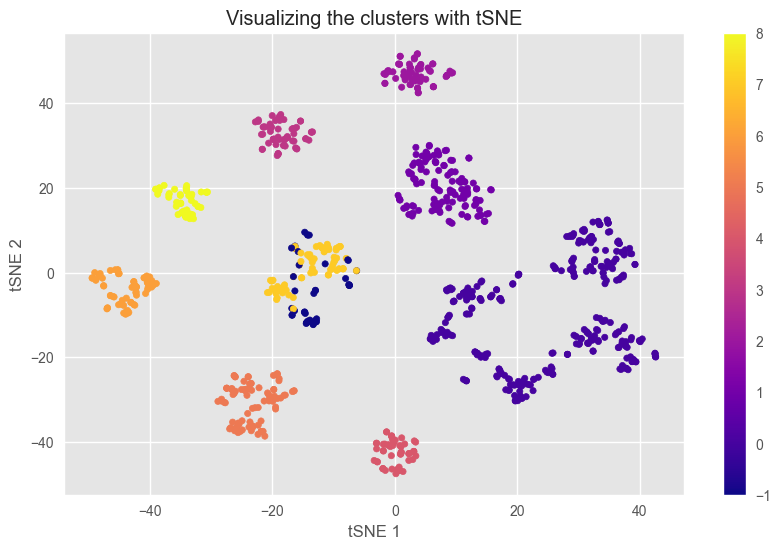

In [40]:
dbscan = DBSCAN(eps=0.14, min_samples=20, metric='hamming').fit(data)
label_dbscan = dbscan.labels_
plot_cluster(tsne_feature,label_dbscan)